# Using the Forward-Forward Algorithm for Image Classification

**Author:** [Suvaditya Mukherjee](https://twitter.com/halcyonrayes)<br>
**Date created:** 2023/01/08<br>
**Last modified:** 2023/01/08<br>
**Description:** Training a Dense-layer model using the Forward-Forward algorithm.

## Setup imports

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import random
from tensorflow.compiler.tf2xla.python import xla

## Load the dataset and visualize the data

We use the `keras.datasets.mnist.load_data()` utility to directly pull the MNIST dataset
in the form of `NumPy` arrays. We then arrange it in the form of the train and test
splits.

Following loading the dataset, we select 4 random samples from within the training set
and visualize them using `matplotlib.pyplot`.

11490434/11490434 [==============================] - 1s 0us/step
4 Random Training samples and labels


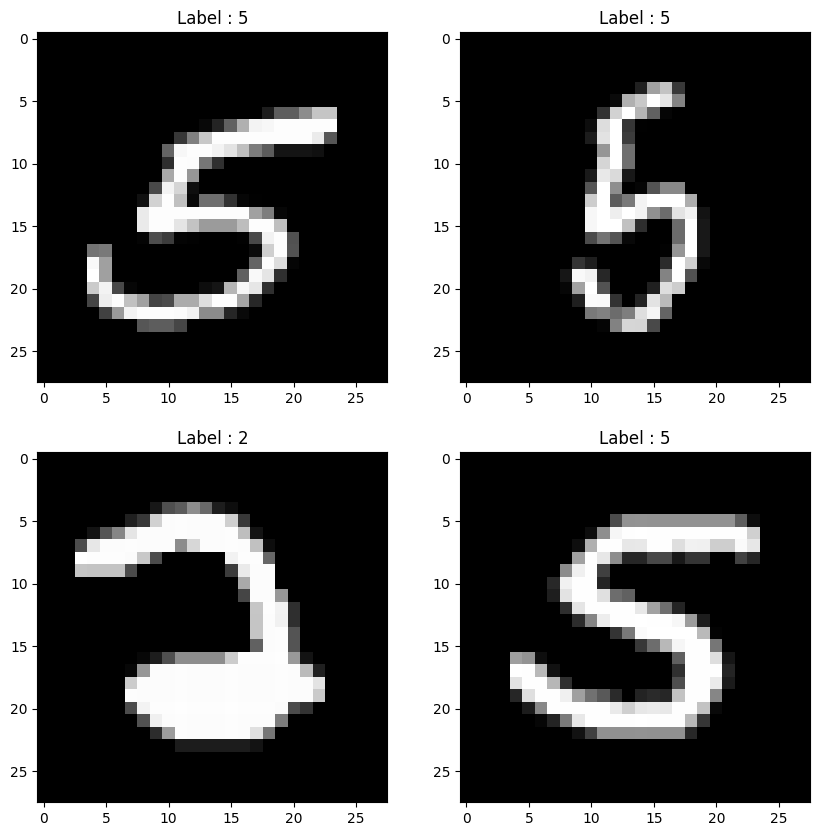

In [2]:
(x_train, y_train), (x_test, y_test) =  keras.datasets.mnist.load_data()

print("4 Random Training samples and labels")
idx1, idx2, idx3, idx4 = random.sample(range(0, x_train.shape[0]), 4)

img1 = (x_train[idx1], y_train[idx1])
img2 = (x_train[idx2], y_train[idx2])
img3 = (x_train[idx3], y_train[idx3])
img4 = (x_train[idx4], y_train[idx4])

imgs = [img1, img2, img3, img4]

plt.figure(figsize=(10, 10))

for idx, item in enumerate(imgs):
    image, label = item[0], item[1]
    plt.subplot(2, 2, idx + 1)
    plt.imshow(image, cmap="gray")
    plt.title(f"Label : {label}")
plt.show()

In [3]:

class FFDense(keras.layers.Layer):
    """
    A custom ForwardForward-enabled Dense layer. It has an implementation of the
    Forward-Forward network internally for use.
    This layer must be used in conjunction with the `FFNetwork` model.
    """

    def __init__(
        self,
        units,
        optimizer,
        loss_metric,
        num_epochs=70,
        use_bias=True,
        kernel_initializer="glorot_uniform",
        bias_initializer="zeros",
        kernel_regularizer=None,
        bias_regularizer=None,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.dense = keras.layers.Dense(
            units=units,
            use_bias=use_bias,
            kernel_initializer=kernel_initializer,
            bias_initializer=bias_initializer,
            kernel_regularizer=kernel_regularizer,
            bias_regularizer=bias_regularizer,
        )
        self.relu = keras.layers.ReLU()
        self.optimizer = optimizer
        self.loss_metric = loss_metric
        self.threshold = 2
        self.num_epochs = num_epochs

    def call(self, x):
        x = tf.cast(x, dtype=tf.float32)
        x_norm = tf.norm(x, ord=2, axis=1, keepdims=True)
        x_norm = x_norm + 1e-4
        x_dir = x / x_norm
        res = self.dense(x_dir)
        return self.relu(res)

    def forward_forward(self, x_pos, x_neg):
        
        for i in range(self.num_epochs):
            with tf.GradientTape() as tape:
                g_pos = tf.math.reduce_mean(tf.math.pow(self.call(x_pos), 2), 1)
                g_neg = tf.math.reduce_mean(tf.math.pow(self.call(x_neg), 2), 1)

                margin_loss = tf.maximum(0., self.threshold - g_pos + g_neg)
                mean_margin_loss = tf.reduce_mean(margin_loss)

                self.loss_metric.update_state([mean_margin_loss])
            gradients = tape.gradient(mean_margin_loss, self.dense.trainable_weights)
            self.optimizer.apply_gradients(zip(gradients, self.dense.trainable_weights))

        return (
            tf.stop_gradient(self.call(x_pos)),
            tf.stop_gradient(self.call(x_neg)),
            self.loss_metric.result(),
        )


In [4]:

class FFNetwork(keras.Model):
    """
    A `keras.Model` that supports a `FFDense` network creation. This model
    can work for any kind of classification task. It has an internal
    implementation with some details specific to the MNIST dataset which can be
    changed as per the use-case.
    """

    def __init__(
        self,
        dims,
        layer_optimizer=keras.optimizers.legacy.Adam(learning_rate=0.09),
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.layer_optimizer = layer_optimizer
        self.loss_var = tf.Variable(0.0, trainable=False, dtype=tf.float32)
        self.loss_count = tf.Variable(0.0, trainable=False, dtype=tf.float32)
        self.layer_list = [keras.Input(shape=(dims[0],))]
        for d in range(3):
            self.layer_list += [
                FFDense(
                    200,
                    optimizer=self.layer_optimizer,
                    loss_metric=keras.metrics.Mean(),
                )
            ]


    @tf.function(reduce_retracing=True)
    def overlay_y_on_x(self, data):
        X_sample, y_sample = data

        max_sample = tf.reduce_max(X_sample, axis=0, keepdims=True)
        max_sample = tf.cast(max_sample, dtype=tf.float32)
        X_zeros = tf.zeros([10], dtype=tf.float32)
        X_update = xla.dynamic_update_slice(X_zeros, max_sample, [y_sample])
        X_sample = xla.dynamic_update_slice(X_sample, X_update, [0])
        return X_sample, y_sample

    @tf.function(reduce_retracing=True)
    def predict_one_sample(self, x):
        goodness_per_label = []
        x = tf.reshape(x, [tf.shape(x)[0] * tf.shape(x)[1]])
        for label in range(10):
            h, label = self.overlay_y_on_x(data=(x, label))
            h = tf.reshape(h, [-1, tf.shape(h)[0]])
            goodness = []
            for layer_idx in range(1, len(self.layer_list)):
                layer = self.layer_list[layer_idx]
                h = layer(h)
                goodness += [tf.math.reduce_mean(tf.math.pow(h, 2), 1)]
            goodness_per_label += [
                tf.expand_dims(tf.reduce_sum(goodness, keepdims=True), 1)
            ]
        goodness_per_label = tf.concat(goodness_per_label, 1)
        return tf.cast(tf.argmax(goodness_per_label, 1), tf.float32)

    def predict(self, data):
        x = data
        preds = list()
        preds = tf.map_fn(fn=self.predict_one_sample, elems=x)
        return np.asarray(preds, dtype=int)

    @tf.function(jit_compile=True)
    def train_step(self, data):
        x, y = data
        x = tf.cast(x, dtype=tf.float32)
        y = tf.cast(y, dtype=tf.int32)

        # Flatten op
        x = tf.reshape(x, [-1, tf.shape(x)[1] * tf.shape(x)[2]])

        x_pos, y = tf.map_fn(fn=self.overlay_y_on_x, elems=(x, y))
        
        random_y = tf.random.shuffle(y)
        x_neg, y = tf.map_fn(fn=self.overlay_y_on_x, elems=(x, random_y))
        x_neg = x_neg + tf.random.normal(shape=tf.shape(x_neg), mean=0.0, stddev=0.1)

        h_pos, h_neg = x_pos, x_neg

        for idx, layer in enumerate(self.layers):
            if isinstance(layer, FFDense):
                print(f"Training layer {idx+1} now : ")
                h_pos, h_neg, loss = layer.forward_forward(h_pos, h_neg)
                self.loss_var.assign_add(loss)
                self.loss_count.assign_add(1.0)
            else:
                print(f"Passing layer {idx+1} now : ")
                x = layer(x)
        mean_res = tf.math.divide(self.loss_var, self.loss_count)
        return {"FinalLoss": mean_res}


## Convert MNIST `NumPy` arrays to `tf.data.Dataset`

We now perform some preliminary processing on the `NumPy` arrays and then convert them
into the `tf.data.Dataset` format which allows for optimized loading.

In [5]:
x_train = x_train.astype(float) / 255
x_test = x_test.astype(float) / 255
y_train = y_train.astype(int)
y_test = y_test.astype(int)

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

train_dataset = train_dataset.batch(60000)
test_dataset = test_dataset.batch(10000)

## Fit the network and visualize results

Having performed all previous set-up, we are now going to run `model.fit()` and run 250
model epochs, which will perform 50*250 epochs on each layer. We get to see the plotted loss
curve as each layer is trained.

In [6]:
model = FFNetwork(dims=[784])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.06),
    loss="mse",
    jit_compile=True,
    metrics=[keras.metrics.Mean()],
)

epochs = 250
history = model.fit(train_dataset, epochs=epochs)

Epoch 1/250
Training layer 1 now : 
Training layer 2 now : 
Training layer 3 now : 
Training layer 1 now : 
Training layer 2 now : 
Training layer 3 now : 
1/1 [==============================] - 186s 186s/step - FinalLoss: 1.3707
Epoch 2/250
1/1 [==============================] - 4s 4s/step - FinalLoss: 1.2854
Epoch 3/250
1/1 [==============================] - 4s 4s/step - FinalLoss: 1.2327
Epoch 4/250
1/1 [==============================] - 4s 4s/step - FinalLoss: 1.1839
Epoch 5/250
1/1 [==============================] - 4s 4s/step - FinalLoss: 1.1569
Epoch 6/250
1/1 [==============================] - 4s 4s/step - FinalLoss: 1.1193
Epoch 7/250
1/1 [==============================] - 5s 5s/step - FinalLoss: 1.0880
Epoch 8/250
1/1 [==============================] - 4s 4s/step - FinalLoss: 1.0548
Epoch 9/250
1/1 [==============================] - 4s 4s/step - FinalLoss: 1.0171
Epoch 10/250
1/1 [==============================] - 5s 5s/step - FinalLoss: 0.9844
Epoch 11/250
1/1 [=============

## Perform inference and testing

Having trained the model to a large extent, we now see how it performs on the
test set. We calculate the Accuracy Score to understand the results closely.

The test confusion matrix is : 
 [[ 866    1    1    8    0   53   25    6   20    0]
 [   0 1109    2   13    0    4    2    1    4    0]
 [   9    6  713  160   22    0   38   12   72    0]
 [   4   12    6  918    0    1    3   22   44    0]
 [   0   19    1    0  829    4   19   31   73    6]
 [  13    4    2  236    9  539   15    7   66    1]
 [  15    9   13    5    7   26  867    2   14    0]
 [   0   20   13    8    6    1    0  928   50    2]
 [   2   24    6  166    7   35   10   23  701    0]
 [   2   15    0   20  475   10    4  279  128   76]]
Test Error : 24.539999999999996%
F1 score: 0.7254313012797804


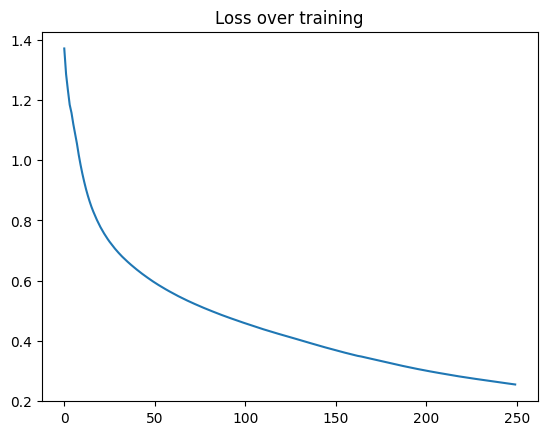

In [8]:
# import confusion matrix
from sklearn.metrics import confusion_matrix
x_test = tf.cast(x_test, dtype=tf.float32)

preds = model.predict(tf.convert_to_tensor(x_test))
preds = preds.reshape((preds.shape[0], preds.shape[1]))

results = accuracy_score(preds, y_test)
error_rate = 1 - results

cm = confusion_matrix(y_test, preds)
total = sum(sum(cm))
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])


print("The test confusion matrix is : \n", cm)
print(f"Test Error : {error_rate*100}%")
# print(f"Test Sensitivity : {sensitivity*100}%")
# print(f"Test Specificity : {specificity*100}%")
# f1 = 2 * (sensitivity * specificity) / (sensitivity + specificity)
# print(f"Test F1 score : {f1*100}%")

from sklearn.metrics import f1_score
f1 = f1_score(y_test, preds, average='macro')
print('F1 score:', f1)


plt.plot(range(len(history.history["FinalLoss"])), history.history["FinalLoss"])
plt.title("Loss over training")
plt.show()